# Othello

This code is based on the code from the website https://inventwithpython.com/reversi.py except I've modified it to change the look of the display.

Just for reference in case we'd like to use a different base program, here are others that I found (but I thought this one was the best):

http://dhconnelly.com/paip-python/docs/paip/othello.html

http://code.activestate.com/recipes/580698-reversi-othello/




In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
#import tensorflow as tf
import os
import sys
import copy

In [2]:
def drawBoard(board):
        ax = plt.gca();
        plt.imshow(board, cmap='Blues')
        plt.clim(0,1)

        # Major ticks
        ax.set_xticks(np.arange(0, 8, 1));
        ax.set_yticks(np.arange(0, 8, 1));

        # Labels for major ticks
        ax.set_xticklabels(np.arange(0, 8, 1));
        ax.set_yticklabels(np.arange(0, 8, 1));

        # Minor ticks
        ax.set_xticks(np.arange(-.5, 8, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 8, 1), minor=True);

        #grid lines
        ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

        plt.show()        

def resetBoard(board):
    # Blanks out the board it is passed, except for the original starting position.
    for x in range(8):
        for y in range(8):
            board[x][y] = 0

    # Starting pieces:
    board[3][3] = 1     #X=1
    board[3][4] = 0.5   #O=0.5
    board[4][3] = 0.5
    board[4][4] = 1        


def getNewBoard():
    # Creates a brand new, blank board data structure.
    board = []
    for i in range(8):
        board.append([0] * 8)
    return board



def isValidMove(board, tile, xstart, ystart):
    # Returns False if the player's move on space xstart, ystart is invalid.
    # If it is a valid move, returns a list of spaces that would become the player's if they made a move here.
    if board[xstart][ystart] != 0 or not isOnBoard(xstart, ystart):
        return False

    board[xstart][ystart] = tile # temporarily set the tile on the board.

    if tile == 1:
        otherTile = 0.5
    else:
        otherTile = 1

    tilesToFlip = []
    for xdirection, ydirection in [[0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1, -1], [-1, 0], [-1, 1]]:
        x, y = xstart, ystart
        x += xdirection # first step in the direction
        y += ydirection # first step in the direction
        if isOnBoard(x, y) and board[x][y] == otherTile:
            # There is a piece belonging to the other player next to our piece.
            x += xdirection
            y += ydirection
            if not isOnBoard(x, y):
                continue
            while board[x][y] == otherTile:
                x += xdirection
                y += ydirection
                if not isOnBoard(x, y): # break out of while loop, then continue in for loop
                    break
            if not isOnBoard(x, y):
                continue
            if board[x][y] == tile:
                # There are pieces to flip over. Go in the reverse direction until we reach the original space, noting all the tiles along the way.
                while True:
                    x -= xdirection
                    y -= ydirection
                    if x == xstart and y == ystart:
                        break
                    tilesToFlip.append([x, y])

    board[xstart][ystart] = 0 # restore the empty space
    if len(tilesToFlip) == 0: # If no tiles were flipped, this is not a valid move.
        return False
    return tilesToFlip


def isOnBoard(x, y):
    # Returns True if the coordinates are located on the board.
    return x >= 0 and x <= 7 and y >= 0 and y <=7


def getBoardWithValidMoves(board, tile):
    # Returns a new board with . marking the valid moves the given player can make.
    dupeBoard = getBoardCopy(board)

    for x, y in getValidMoves(dupeBoard, tile):
        dupeBoard[x][y] = 0.2
    return dupeBoard


def getValidMoves(board, tile):
    # Returns a list of [x,y] lists of valid moves for the given player on the given board.
    validMoves = []

    for x in range(8):
        for y in range(8):
            if isValidMove(board, tile, x, y) != False:
                validMoves.append([x, y])
    return validMoves


def getScoreOfBoard(board):
    # Determine the score by counting the tiles. Returns a dictionary with keys 'X' and 'O'.
    xscore = 0
    oscore = 0
    for x in range(8):
        for y in range(8):
            if board[x][y] == 1:
                xscore += 1
            if board[x][y] == 0.5:
                oscore += 1
    return {'Dark':xscore, 'Light':oscore}

def playAgain():
    # This function returns True if the player wants to play again, otherwise it returns False.
    print('Do you want to play again? (yes or no)')
    return input().lower().startswith('y')


def makeMove(board, tile, xstart, ystart):
    # Place the tile on the board at xstart, ystart, and flip any of the opponent's pieces.
    # Returns False if this is an invalid move, True if it is valid.
    tilesToFlip = isValidMove(board, tile, xstart, ystart)

    if tilesToFlip == False:
        return False

    board[xstart][ystart] = tile
    for x, y in tilesToFlip:
        board[x][y] = tile
    return True


def getBoardCopy(board):
    # Make a duplicate of the board list and return the duplicate.
    dupeBoard = getNewBoard()

    for x in range(8):
        for y in range(8):
            dupeBoard[x][y] = board[x][y]

    return dupeBoard


def isOnCorner(x, y):
    # Returns True if the position is in one of the four corners.
    return (x == 0 and y == 0) or (x == 7 and y == 0) or (x == 0 and y == 7) or (x == 7 and y == 7)


def getPlayerMove(board, playerTile):
    # Let the player type in their move.
    # Returns the move as [x, y] (or returns the strings 'hints' or 'quit')
    DIGITS0TO7 = '0 1 2 3 4 5 6 7'.split()
    while True:
        print('Enter your move, or type quit to end the game, or hints to turn off/on hints.')
        move = input().lower()
        if move == 'quit':
            return 'quit'
        if move == 'hints':
            return 'hints'

        if len(move) == 2 and move[0] in DIGITS0TO7 and move[1] in DIGITS0TO7:
            x = int(move[0]) 
            y = int(move[1])
            if isValidMove(board, 0.5, x, y) == False:
                continue
            else:
                break
        else:
            print('That is not a valid move. Type the x digit (0-7), then the y digit (0-7).')
            print('For example, 07 will be the top-right corner.')

    return [x, y]


def getComputerMove(board, computerTile):
    # Given a board and the computer's tile, determine where to
    # move and return that move as a [x, y] list.
    possibleMoves = getValidMoves(board, 1)

    # randomize the order of the possible moves
    random.shuffle(possibleMoves)

    # always go for a corner if available.
    for x, y in possibleMoves:
        if isOnCorner(x, y):
            return [x, y]

    # Go through all the possible moves and remember the best scoring move
    bestScore = -1
    for x, y in possibleMoves:
        dupeBoard = getBoardCopy(board)
        makeMove(dupeBoard, computerTile, x, y)
        score = getScoreOfBoard(dupeBoard)[computerTile]
        if score > bestScore:
            bestMove = [x, y]
            bestScore = score
    return bestMove


def showPoints(playerTile, computerTile):
    # Prints out the current score.
    scores = getScoreOfBoard(mainBoard)
    print('You have %s points. The computer has %s points.' % (scores['Light'], scores['Dark']))

Welcome to Reversi!
The computer will go first.


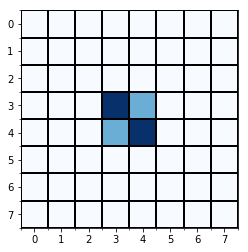

You have 2 points. The computer has 2 points.
Press Enter to see the computer's move.


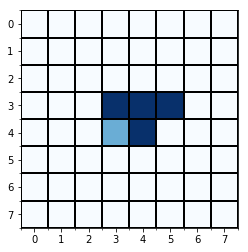

You have 1 points. The computer has 4 points.
Enter your move, or type quit to end the game, or hints to turn off/on hints.
25


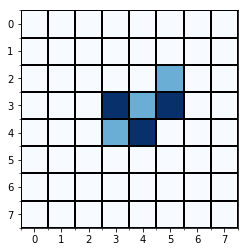

You have 3 points. The computer has 3 points.
Press Enter to see the computer's move.


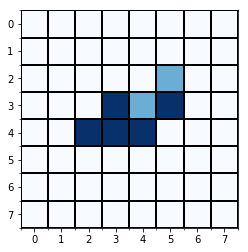

You have 2 points. The computer has 5 points.
Enter your move, or type quit to end the game, or hints to turn off/on hints.
hints


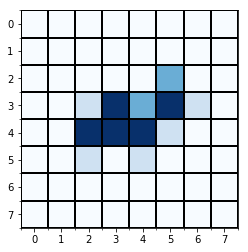

You have 2 points. The computer has 5 points.
Enter your move, or type quit to end the game, or hints to turn off/on hints.
32


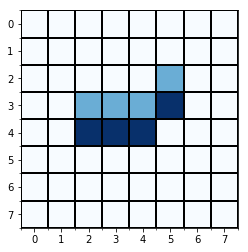

You have 4 points. The computer has 4 points.
Press Enter to see the computer's move.


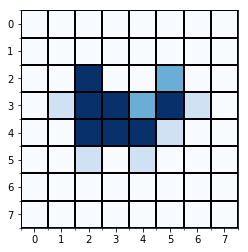

You have 2 points. The computer has 7 points.
Enter your move, or type quit to end the game, or hints to turn off/on hints.
quit
Thanks for playing!


SystemExit: 

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
print('Welcome to Reversi!')

while True:
    # Reset the board and game.
    mainBoard = getNewBoard()
    resetBoard(mainBoard)
    playerTile = 'Light'
    computerTile = 'Dark'
    
    showHints = False
    turn = 'computer' #whoGoesFirst()
    print('The ' + turn + ' will go first.')

    while True:
        if turn == 'player':
            # Player's turn.
            if showHints:
                validMovesBoard = getBoardWithValidMoves(mainBoard, 0.5)
                drawBoard(validMovesBoard)
            else:
                drawBoard(mainBoard)
            showPoints(playerTile, computerTile)
            move = getPlayerMove(mainBoard, playerTile)
            if move == 'quit':
                print('Thanks for playing!')
                sys.exit() # terminate the program
            elif move == 'hints':
                showHints = not showHints
                continue
            else:
                makeMove(mainBoard, 0.5, move[0], move[1])

            if getValidMoves(mainBoard, 1) == []:
                break
            else:
                turn = 'computer'

        else:
            # Computer's turn.
            drawBoard(mainBoard)
            showPoints(playerTile, computerTile)
            input('Press Enter to see the computer\'s move.')
            x, y = getComputerMove(mainBoard, computerTile)
            makeMove(mainBoard, 1 , x, y)

            if getValidMoves(mainBoard, 0.5) == []:
                break
            else:
                turn = 'player'

    # Display the final score.
    drawBoard(mainBoard)
    scores = getScoreOfBoard(mainBoard)
    print('Dark scored %s points. Light scored %s points.' % (scores['Dark'], scores['Light']))
    if scores['Light'] > scores['Dark']:
        print('You beat the computer by %s points! Congratulations!' % (scores['Light'] - scores['Dark']))
    elif scores['Light'] < scores['Dark']:
        print('You lost. The computer beat you by %s points.' % (scores['Dark'] - scores['Light']))
    else:
        print('The game was a tie!')

    if not playAgain():
        break